# Superposing a PACE Product on a True Color Background

Carina Poulin and Ivona Cetinic, based on the PACE Hackweek Tutorial started by Anna Windle and Continued by Patrick Gray

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA ocean color data.

</div>

[edl]: https://urs.earthdata.nasa.gov/

## 1. Setup

We begin by importing the packages used in this notebook.

In [1]:
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import LogNorm
import cmocean
from matplotlib import pyplot
from cartopy.crs import Orthographic, PlateCarree

The last import provides a preview of the `DataTree` object. Once it is fully integrated into XArray,
the additional import won't be needed, as the function will be available as `xr.open_datree`.

[back to top](#Contents)

## 2. NASA Earthdata Authentication

Next, we authenticate using our Earthdata Login
credentials. Authentication is not needed to search publicaly
available collections in Earthdata, but is always needed to access
data. We can use the `login` method from the `earthaccess`
package. This will create an authenticated session when we provide a
valid Earthdata Login username and password. The `earthaccess`
package will search for credentials defined by **environmental
variables** or within a **.netrc** file saved in the home
directory. If credentials are not found, an interactive prompt will
allow you to input credentials.

<div class="alert alert-info" role="alert">
    
The `persist=True` argument ensures any discovered credentials are
stored in a `.netrc` file, so the argument is not necessary (but
it's also harmless) for subsequent calls to `earthaccess.login`.

</div>

In [2]:
auth = earthaccess.login(persist=True)

[back to top](#Contents)

## 3. Search for Data

Collections on NASA Earthdata are discovered with the
`search_datasets` function, which accepts an `instrument` filter as an
easy way to get started. Each of the items in the list of
collections returned has a "short-name".

In [3]:
results = earthaccess.search_datasets(instrument="oci")

<div class="alert alert-info" role="alert">
The short name can also be found on <a href="https://search.earthdata.nasa.gov/search?fi=SPEXone!HARP2!OCI" target="_blank"> Eartdata Search</a>, directly under the collection name, after clicking on the "i" button for a collection in any search result.
</div>

Next, we use the `search_data` function to find granules within a
collection. Let's use the `short_name` for the PACE/OCI Level-2 near real time (NRT), product for biogeochemical properties (although you can
search for granules accross collections too).



The `count` argument limits the number of granules whose metadata is returned and stored in the `results` list.

We can refine our search by passing more parameters that describe
the spatiotemporal domain of our use case. Here, we use the
`temporal` parameter to request a date range and the `bounding_box`
parameter to request granules that intersect with a bounding box. We
can even provide a `cloud_cover` threshold to limit files that have
a lower percetnage of cloud cover. We do not provide a `count`, so
we'll get all granules that satisfy the constraints.

In [4]:
tspan = ("2025-05-24", "2025-05-26")
bbox = (155.3565, 49.83302, 177.06386, 60.34828)
#clouds = (0, 60)

In [5]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
   
     granule_name="*T003055.L2.OC_BGC.V3_0.*"
    #cloud_cover=clouds,
)

In [6]:
len(results)

1

In [7]:
results[0]

Collection: {'ShortName': 'PACE_OCI_L2_BGC_NRT', 'Version': '3.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 64.87972, 'Longitude': -162.57166}, {'Latitude': 57.11694, 'Longitude': 148.24622}, {'Latitude': 41.28767, 'Longitude': 163.20694}, {'Latitude': 47.21869, 'Longitude': -163.7326}, {'Latitude': 64.87972, 'Longitude': -162.57166}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-05-26T00:35:54Z', 'BeginningDateTime': '2025-05-26T00:30:55Z'}}
Size(MB): 13.907867431640625
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250526T003055.L2.OC_BGC.V3_0.NRT.nc']

## 4. Open L2 Data

Let's go ahead and open a couple granules using `xarray`. The `earthaccess.open` function is used when you want to directly read bytes from a remote filesystem, but not download a whole file. When
running code on a host with direct access to the NASA Earthdata
Cloud, you don't need to download the data and `earthaccess.open`
is the way to go.

In [8]:
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

The `paths` list contains references to files on a remote filesystem. The ob-cumulus-prod-public is the S3 Bucket in AWS us-west-2 region.

In [9]:
dataset = xr.open_dataset(paths[0])
dataset

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/45)
    title:                             OCI Level-2 Data BGC
    product_name:                      PACE_OCI.20250526T003055.L2.OC_BGC.V3_...
    processing_version:                3.0
    history:                           l2gen par=/data14/sdpsoper/vdc/vpu13/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -162.57034
    geospatial_lon_min:                148.24622
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9744945168495178

Notice that this `xarray.Dataset` has nothing but "Attributes". The NetCDF data model includes multi-group hierarchies within a single file, where each group maps to an `xarray.Dataset`. The whole file maps to a `DataTree`, which we will only use lightly because the implementation in XArray remains under development.

In [10]:
datatree = open_datatree(paths[0])
datatree

/tmp/ipykernel_394/995226554.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  datatree = open_datatree(paths[0])


<xarray.DataTree>
Group: /
│   Attributes: (12/45)
│       title:                             OCI Level-2 Data BGC
│       product_name:                      PACE_OCI.20250526T003055.L2.OC_BGC.V3_...
│       processing_version:                3.0
│       history:                           l2gen par=/data14/sdpsoper/vdc/vpu13/w...
│       instrument:                        OCI
│       platform:                          PACE
│       ...                                ...
│       geospatial_lon_max:                -162.57034
│       geospatial_lon_min:                148.24622
│       startDirection:                    Ascending
│       endDirection:                      Ascending
│       day_night_flag:                    Day
│       earth_sun_distance_correction:     0.9744945168495178
├── Group: /sensor_band_parameters
│       Dimensions:      (number_of_bands: 286, number_of_reflective_bands: 286)
│       Dimensions without coordinates: number_of_bands, number_of_reflective_bands
│       Data variables:
│           wavelength   (number_of_bands) float64 2kB ...
│           vcal_gain    (number_of_reflective_bands) float32 1kB ...
│           vcal_offset  (number_of_reflective_bands) float32 1kB ...
│           F0           (number_of_reflective_bands) float32 1kB ...
│           aw           (number_of_reflective_bands) float32 1kB ...
│           bbw          (number_of_reflective_bands) float32 1kB ...
│           k_oz         (number_of_reflective_bands) float32 1kB ...
│           k_no2        (number_of_reflective_bands) float32 1kB ...
│           Tau_r        (number_of_reflective_bands) float32 1kB ...
├── Group: /scan_line_attributes
│       Dimensions:  (number_of_lines: 1710)
│       Dimensions without coordinates: number_of_lines
│       Data variables: (12/13)
│           year     (number_of_lines) float64 14kB ...
│           day      (number_of_lines) timedelta64[ns] 14kB ...
│           msec     (number_of_lines) timedelta64[ns] 14kB ...
│           time     (number_of_lines) datetime64[ns] 14kB ...
│           detnum   (number_of_lines) float32 7kB ...
│           mside    (number_of_lines) float32 7kB ...
│           ...       ...
│           clon     (number_of_lines) float32 7kB ...
│           elon     (number_of_lines) float32 7kB ...
│           slat     (number_of_lines) float32 7kB ...
│           clat     (number_of_lines) float32 7kB ...
│           elat     (number_of_lines) float32 7kB ...
│           csol_z   (number_of_lines) float32 7kB ...
├── Group: /geophysical_data
│       Dimensions:           (number_of_lines: 1710, pixels_per_line: 1272)
│       Dimensions without coordinates: number_of_lines, pixels_per_line
│       Data variables:
│           chlor_a           (number_of_lines, pixels_per_line) float32 9MB ...
│           carbon_phyto      (number_of_lines, pixels_per_line) float32 9MB ...
│           poc               (number_of_lines, pixels_per_line) float32 9MB ...
│           chlor_a_unc       (number_of_lines, pixels_per_line) float32 9MB ...
│           carbon_phyto_unc  (number_of_lines, pixels_per_line) float32 9MB ...
│           l2_flags          (number_of_lines, pixels_per_line) int32 9MB ...
├── Group: /navigation_data
│       Dimensions:    (number_of_lines: 1710, pixels_per_line: 1272)
│       Dimensions without coordinates: number_of_lines, pixels_per_line
│       Data variables:
│           longitude  (number_of_lines, pixels_per_line) float32 9MB ...
│           latitude   (number_of_lines, pixels_per_line) float32 9MB ...
│           tilt       (number_of_lines) float32 7kB ...
│       Attributes:
│           gringpointlongitude:  [ 163.20694 -163.7326  -162.57166  148.24622]
│           gringpointlatitude:   [41.287666 47.21869  64.87972  57.11694 ]
│           gringpointsequence:   [1 2 3 4]
└── Group: /processing_control
    │   Attributes:
    │       software_name:     l2gen
    │       software_version:  9.11.0-V2025.1
    │       input_sources:     PACE_OCI.2

In [11]:
dataset = xr.merge(datatree.to_dict().values())
dataset = dataset.set_coords(("longitude", "latitude"))

dataset

<xarray.Dataset> Size: 70MB
Dimensions:           (number_of_bands: 286, number_of_reflective_bands: 286,
                       number_of_lines: 1710, pixels_per_line: 1272)
Coordinates:
    longitude         (number_of_lines, pixels_per_line) float32 9MB ...
    latitude          (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/29)
    wavelength        (number_of_bands) float64 2kB ...
    vcal_gain         (number_of_reflective_bands) float32 1kB ...
    vcal_offset       (number_of_reflective_bands) float32 1kB ...
    F0                (number_of_reflective_bands) float32 1kB ...
    aw                (number_of_reflective_bands) float32 1kB ...
    bbw               (number_of_reflective_bands) float32 1kB ...
    ...                ...
    carbon_phyto      (number_of_lines, pixels_per_line) float32 9MB ...
    poc               (number_of_lines, pixels_per_line) float32 9MB ...
    chlor_a_unc       (number_of_lines, pixels_per_line) float32 9MB ...
    carbon_phyto_unc  (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags          (number_of_lines, pixels_per_line) int32 9MB ...
    tilt              (number_of_lines) float32 7kB ...
Attributes: (12/45)
    title:                             OCI Level-2 Data BGC
    product_name:                      PACE_OCI.20250526T003055.L2.OC_BGC.V3_...
    processing_version:                3.0
    history:                           l2gen par=/data14/sdpsoper/vdc/vpu13/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -162.57034
    geospatial_lon_min:                148.24622
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9744945168495178

Here let's play with the raw data with lines as the y axis and pixels as the x axis

Let's set the coordinates and plot with latitude and longitude so we can project the data onto a grid.

And if we want to get fancy, we can add the coastline.

But really chla is typically lognormally distributed to let's use a log normal scale

In [12]:
min_lon = 150
min_lat = 50
max_lon = 179.9
max_lat = 62

mask_lon = (dataset.longitude >= min_lon) & (dataset.longitude <= max_lon)
mask_lat = (dataset.latitude >= min_lat) & (dataset.latitude <= max_lat)

dataset_fully = dataset["chlor_a"].where(mask_lon & mask_lat, drop=True)


In [13]:
dataset_fully


<xarray.DataArray 'chlor_a' (number_of_lines: 1270, pixels_per_line: 997)> Size: 5MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 5MB 160.3 ... 179.1
    latitude   (number_of_lines, pixels_per_line) float32 5MB 45.55 ... 63.93
Dimensions without coordinates: number_of_lines, pixels_per_line
Attributes:
    long_name:      Chlorophyll Concentration, OCI Algorithm
    units:          mg m^-3
    standard_name:  mass_concentration_of_chlorophyll_in_sea_water
    valid_min:      0.001
    valid_max:      100.0
    reference:      Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a alg...

In [14]:
dataset_diato=1.5*dataset_fully**1.9


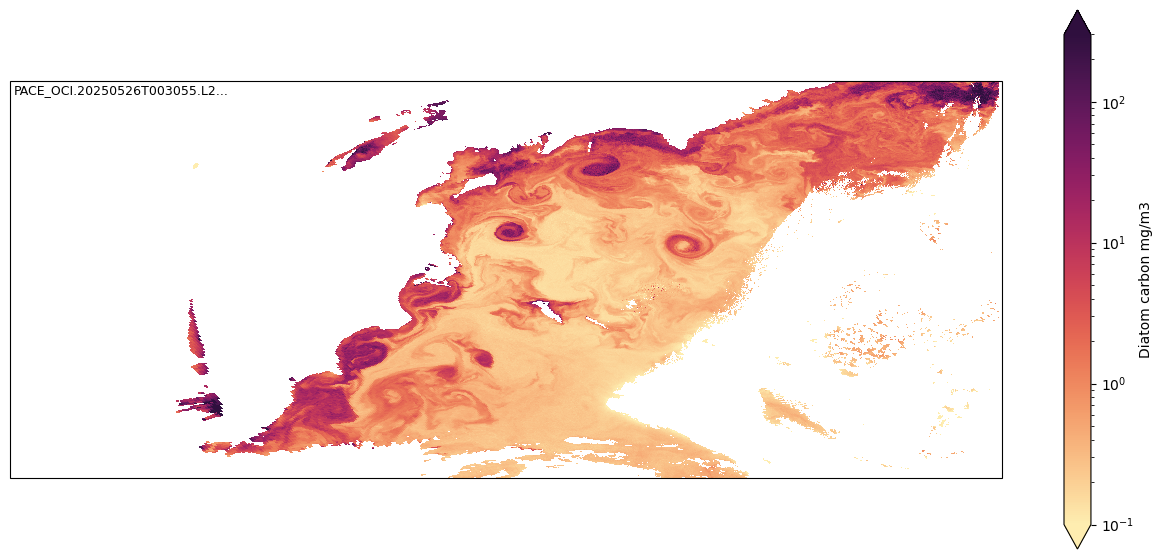

In [15]:
fig = plt.figure(figsize=(16,7))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.coastlines()
#ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = dataset_diato.plot(x="longitude", y="latitude", cmap=cmocean.cm.matter, label='Data Value', cbar_kwargs={'label': 'Diatom carbon mg/m3'}, norm=LogNorm(vmin=0.1, vmax=300), ax=ax)
                                                                                        
#extent = [150, 180, 50, 62] #limit the geo area
ax.set_xlim(150,180)
ax.set_ylim(50,62)

plt.text(150.1, 61.6, "PACE_OCI.20250526T003055.L2...", fontsize=9, color='black')

plt.savefig('diato.png',dpi=300)#,transparent=True)

In [16]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL_NRT",
   
     granule_name="*20250526T003055*"
    #cloud_cover=clouds,
)
results

[Collection: {'ShortName': 'PACE_OCI_L2_SFREFL_NRT', 'Version': '3.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 64.87972, 'Longitude': -162.57166}, {'Latitude': 57.11694, 'Longitude': 148.24622}, {'Latitude': 41.28767, 'Longitude': 163.20694}, {'Latitude': 47.21869, 'Longitude': -163.7326}, {'Latitude': 64.87972, 'Longitude': -162.57166}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-05-26T00:35:54Z', 'BeginningDateTime': '2025-05-26T00:30:55Z'}}
 Size(MB): 712.9888820648193
 Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250526T003055.L2.SFREFL.V3_0.NRT.nc']]

In [17]:
path = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
datatree = open_datatree(path[0])
dataset = xr.merge(datatree.to_dict().values())
dataset

/tmp/ipykernel_394/229992502.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  datatree = open_datatree(path[0])


<xarray.Dataset> Size: 1GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 122, number_of_lines: 1710,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/27)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    csol_z         (number_of_lines) float32 7kB ...
    rhos           (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
    tilt           (number_of_lines) float32 7kB ...
Attributes: (12/45)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20250526T003055.L2.SFREFL.V3_...
    processing_version:                3.0
    history:                           l2gen par=/data20/sdpsoper/vdc/vpu19/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -162.57034
    geospatial_lon_min:                148.24622
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9744945168495178

In [19]:
dataset = dataset.set_coords(("longitude", "latitude"))
dataset

<xarray.Dataset> Size: 1GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 122, number_of_lines: 1710,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/25)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    clat           (number_of_lines) float32 7kB ...
    elat           (number_of_lines) float32 7kB ...
    csol_z         (number_of_lines) float32 7kB ...
    rhos           (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
    tilt           (number_of_lines) float32 7kB ...
Attributes: (12/45)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20250526T003055.L2.SFREFL.V3_...
    processing_version:                3.0
    history:                           l2gen par=/data20/sdpsoper/vdc/vpu19/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -162.57034
    geospatial_lon_min:                148.24622
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9744945168495178

In [20]:
rgb = dataset["rhos"].sel({"wavelength_3d": [645, 555, 368]}, method="nearest")

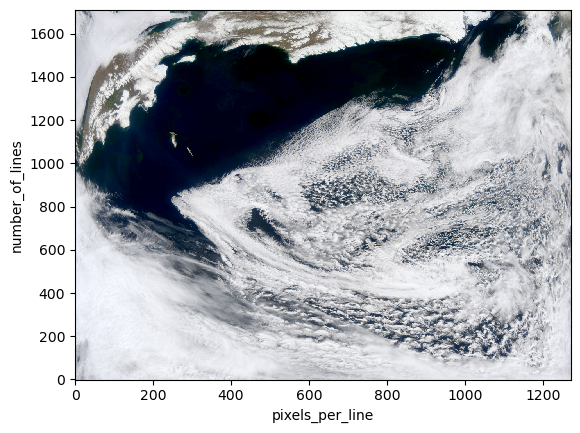

In [21]:
from PIL import Image, ImageEnhance
rgb = dataset["rhos"].sel({"wavelength_3d": [645, 555, 440]}, method="nearest")
scale = 0.01
vmin = 0
vmax = 1.1
gamma = 1
contrast = 1.1
brightness = 1
sharpness = 1.1
saturation = 1

rgb = rgb.where(rgb > 0)
rgb = np.log(rgb / scale) / np.log(1 / scale)
rgb = rgb.where(rgb >= vmin, vmin)
rgb = rgb.where(rgb <= vmax, vmax)    
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
rgb = rgb * gamma
img = rgb * 255
img = img.where(img.notnull(), 0).astype("uint8")
img = Image.fromarray(img.data)
enhancer = ImageEnhance.Contrast(img)
img = enhancer.enhance(contrast)
enhancer = ImageEnhance.Brightness(img)
img = enhancer.enhance(brightness)
enhancer = ImageEnhance.Sharpness(img)
img = enhancer.enhance(sharpness)
enhancer = ImageEnhance.Color(img)
img = enhancer.enhance(saturation)
rgb[:] = np.array(img) / 255

plot = rgb.plot.imshow()

/tmp/ipykernel_394/831966910.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  artist = axes.pcolormesh(


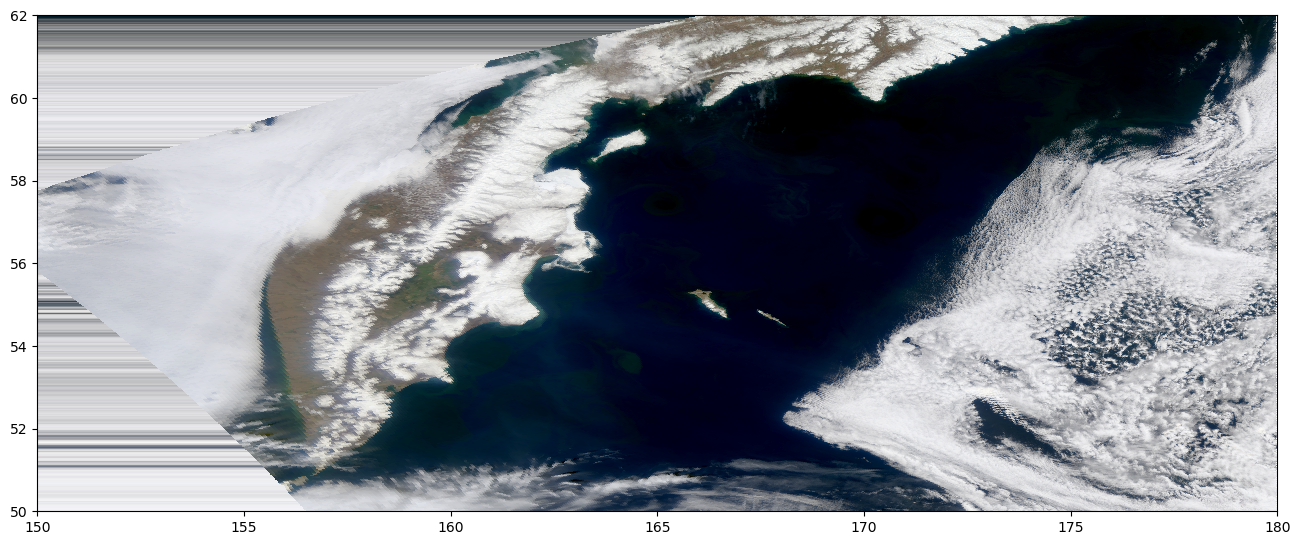

In [23]:
def pcolormesh(rgb, lon_min=None, lon_max=None, lat_min=None, lat_max=None, save_path=None):
    fig = plt.figure(figsize=(16,7))
    axes = plt.subplot()
    artist = axes.pcolormesh(
        rgb["longitude"],
        rgb["latitude"],
        rgb,
        shading="nearest",
        rasterized=True,
    )
    axes.set_aspect("equal")
    # Add limits if provided
    if lon_min is not None and lon_max is not None:
        axes.set_xlim(lon_min, lon_max)
    if lat_min is not None and lat_max is not None:
        axes.set_ylim(lat_min, lat_max)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # export at 300 dpi
    plt.show()

# Usage to save as a PNG:
pcolormesh(
    rgb, 
    lon_min=150, lon_max=180,
    lat_min=50, lat_max=62,
    save_path="my_map.png"
)

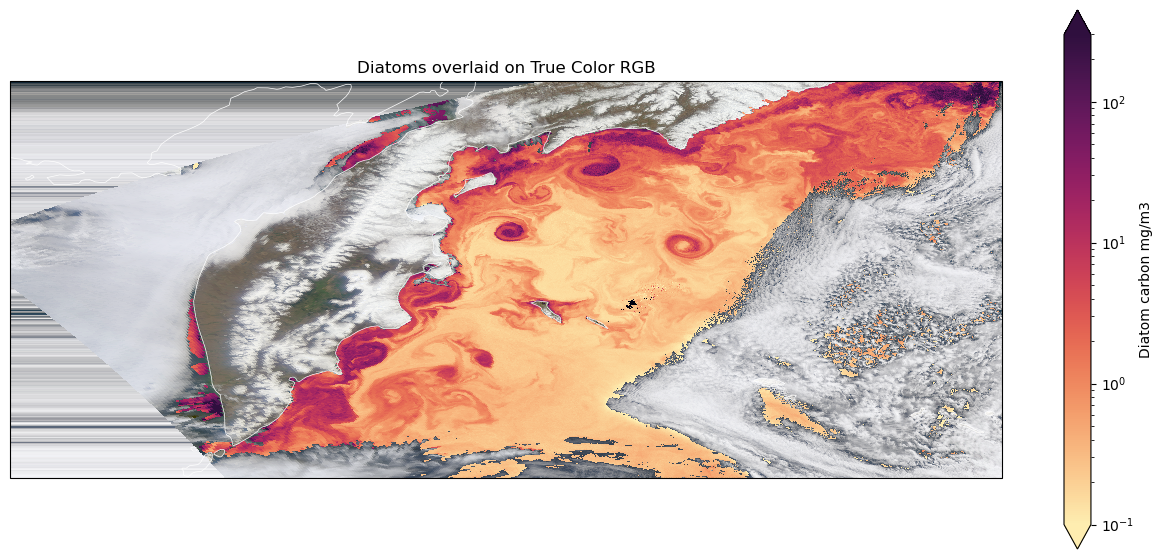

In [25]:
fig = plt.figure(figsize=(16,7))
ax = plt.axes(projection=ccrs.PlateCarree())

# RGB image as background
rgb_artist = ax.pcolormesh(
    rgb["longitude"],
    rgb["latitude"],
    rgb,
    shading="nearest",
    rasterized=True,
    transform=ccrs.PlateCarree()
)

# Overlay
plot = dataset_diato.plot(
    x="longitude", y="latitude",
    cmap=cmocean.cm.matter,
    norm=LogNorm(vmin=0.1, vmax=300),
    ax=ax,
    alpha=1,  # Add transparency so the RGB background shows through, 1 is opaque
    add_colorbar=True,  # Add colorbar for diatoms
    cbar_kwargs={'label': 'Diatom carbon mg/m3'},
    transform=ccrs.PlateCarree()
)

# Limits for both plots
ax.set_xlim(150, 180)
ax.set_ylim(50, 62)
ax.set_aspect("equal")

# Coastlines (optional)
ax.coastlines(resolution='50m', color='white', linewidth=0.5)

plt.title('Diatoms overlaid on True Color RGB')

# Optional: save the combined plot
# plt.savefig("combined_plot.png", dpi=300, bbox_inches='tight')

plt.show()